# Linear Regression Using Sklearn API

1. Dataset - California Housing
2. Linear Regression
3. Training : fit, cross_validate
4. Evaluation : score, cross_val_score

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score, learning_curve, ShuffleSplit, train_test_split, cross_val_predict
from sklearn.impute import KNNImputer

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [50]:
np.random.seed(306)

### ShuffleSplitting

In [51]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

## Importing the dataset

In [52]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Let's Drop the Ocean Proximity for now, I will redo with Ocean Proximity when i will do encoding of categorical values

In [53]:
data = data.drop(columns=['ocean_proximity'])

## Data Exploration is already done in the previous notebook

## Imputing the dataset for missing values

In [54]:
impute = KNNImputer(n_neighbors=2)
imp_data = impute.fit_transform(data)

In [55]:
data = pd.DataFrame(imp_data, columns= data.columns)

## Preprocessing and model building

In [56]:
X = data.drop(columns=['median_house_value'])
y = data['median_house_value']/100000

### Train-test Split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [58]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15480, 8)
(15480,)
(5160, 8)
(5160,)


### Pipeline: processing + model

In [59]:
lin_reg_pipelne = Pipeline([
    ('feature_scaler', StandardScaler()),
    ('lin_reg', LinearRegression())
])

lin_reg_pipelne.fit(X_train,y_train)

,steps,"[('feature_scaler', ...), ('lin_reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


#### Now since we have trained the model, let's check the learnt/estimated weight

In [60]:
print("intercept w_0", lin_reg_pipelne[-1].intercept_)
print("weight vector", lin_reg_pipelne[-1].coef_)

intercept w_0 2.0703489205426377
weight vector [-0.8563372  -0.90688575  0.14784883 -0.17797746  0.5053612  -0.43700256
  0.15889046  0.76852688]


## Model Evaluation


### Score

In [61]:
test_score = lin_reg_pipelne.score(X_test, y_test)
print("Model Peformance on test set", test_score)

train_score = lin_reg_pipelne.score(X_train, y_train)
print("Model Peformance on test set", train_score)

Model Peformance on test set 0.6336637798602007
Model Peformance on test set 0.6374794873372915


### Cross-validate Score

In [62]:
lin_reg_score = cross_val_score(lin_reg_pipelne, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)

print(lin_reg_score)

[-0.48755625 -0.48135806 -0.51232427 -0.50833425 -0.53436955 -0.46500896
 -0.49350831 -0.51064953 -0.48161006 -0.50242713]


In [63]:
print("Linear Regression Model Score", lin_reg_score.mean(), "\n", "std:", lin_reg_score.std())

Linear Regression Model Score -0.4977146360694677 
 std: 0.018912329207589323


### Cross-Validation API

In [64]:
lin_reg_cv_results = cross_validate( lin_reg_pipelne, X_train, y_train, cv=cv,
                                    scoring="neg_mean_squared_error", return_train_score=True, return_estimator=True)

In [65]:
lin_reg_cv_results

{'fit_time': array([0.0052011 , 0.00570583, 0.00298023, 0.00250483, 0.00287509,
        0.003057  , 0.00284004, 0.00282288, 0.00287175, 0.00329185]),
 'score_time': array([0.00085092, 0.00083613, 0.00071287, 0.00065899, 0.00066781,
        0.00083399, 0.0005672 , 0.00069618, 0.00068498, 0.0006721 ]),
 'estimator': [Pipeline(steps=[('feature_scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_sca

In [66]:
train_error = -1 * lin_reg_cv_results['train_score']
test_error= -1 * lin_reg_cv_results['test_score']

print (f"Mean squared error of linear regression model on the train set: \n" 
       f"{train_error.mean ():.3f} +/- {train_error.std():.3f}")
print (f"Mean squared error of linear regression model on the test set: \n"
       f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the train set: 
0.481 +/- 0.005
Mean squared error of linear regression model on the test set: 
0.498 +/- 0.019


### Selecting Best Model

In [67]:
best_model_index = np.argmin(test_error)
selected_model = lin_reg_cv_results['estimator'][best_model_index]

In [68]:
print("Intercept w_0", selected_model['lin_reg'].intercept_)
print("Coefficients w0,w1...wn", selected_model['lin_reg'].coef_)

Intercept w_0 2.074167797157622
Coefficients w0,w1...wn [-0.84511741 -0.89300343  0.1565094  -0.17820223  0.51320044 -0.417118
  0.13516019  0.7739125 ]


### Model Performance

In [69]:
cv_predictions = cross_val_predict(lin_reg_pipelne, X_train, y_train)

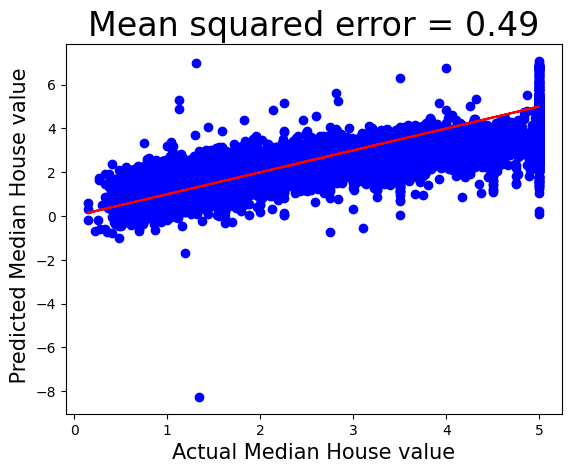

In [70]:
mse_cv = mean_squared_error(y_train, cv_predictions)

plt.scatter(y_train, cv_predictions, color='blue')
plt.plot(y_train, y_train, 'r-')
plt.title(f"Mean squared error = {mse_cv:.2f}", size=24)
plt.xlabel('Actual Median House value', size=15) 
plt.ylabel(' Predicted Median House value', size=15)
plt.show()

## Predictions

In [71]:
test_predictions_cv = selected_model.predict(X_test)
test_predictions_cv[:5]

array([0.58071124, 1.7803052 , 3.03738425, 2.86126058, 2.61860118])

In [72]:
score_cv = selected_model.score(X_test, y_test)

print("Score for best model on Test Dataset is", score_cv)

Score for best model on Test Dataset is 0.6332970421057376


# Baseline Models

In [35]:
from sklearn.model_selection import permutation_test_score
from sklearn.dummy import DummyRegressor

## Linear classifier

In [38]:
lin_reg_cv_results = cross_validate( lin_reg_pipelne, X_train, y_train, cv=cv,
                                    scoring="neg_mean_squared_error", return_train_score=True, return_estimator=True, n_jobs=2)

lin_reg_errors = pd.Series(-lin_reg_cv_results["test_score"], name = "Linear Regression Error")

## Dummy Regressor

In [41]:
def dummy_score_baseline(strategy, constant_val=None, quantile_val = None):
    baseline_model_median = DummyRegressor(strategy=strategy, constant= constant_val, quantile=quantile_val)
    baseline_median_cv_results = cross_validate(baseline_model_median, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=2)

    return pd.Series(-baseline_median_cv_results["test_score"], name="Dummy Regressor Error")

In [42]:
baseline_median_cv_results_errors = dummy_score_baseline(strategy='median')
baseline_mean_cv_results_errors = dummy_score_baseline(strategy='mean')
baseline_constant_cv_results_errors = dummy_score_baseline(strategy='constant', constant_val=2)
baseline_quantile_cv_results_errors = dummy_score_baseline(strategy='quantile', quantile_val=0.55)

#### Let's compare performance of these dummy regressors

In [43]:
dummy_error_df = pd.concat([baseline_median_cv_results_errors, baseline_mean_cv_results_errors,
                            baseline_constant_cv_results_errors, baseline_quantile_cv_results_errors], axis=1)

dummy_error_df.columns= ['Median CV', 'Mean CV', 'Constant CV', 'Quamtile CV']

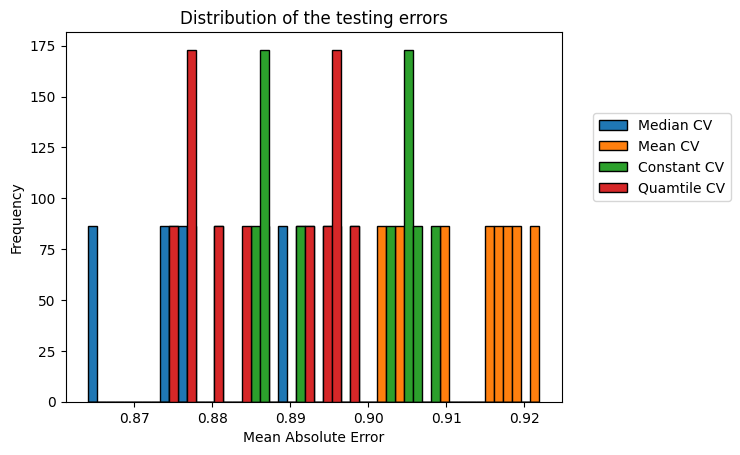

In [44]:
dummy_error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor = (1.05, 0.8), loc = "upper left")
plt.xlabel("Mean Absolute Error")
_ = plt.title( "Distribution of the testing errors")

### Permutation test score

In [45]:
score, permutation_score, pvalue = permutation_test_score(
    lin_reg_pipelne, X_train, y_train,cv=cv, scoring='neg_mean_absolute_error',n_jobs=2, n_permutations=30)

permutation_error = pd.Series(-permutation_score, name="Permuted error")

In [46]:
print(permutation_error)

0     0.914818
1     0.916318
2     0.914770
3     0.911105
4     0.912916
5     0.914281
6     0.916356
7     0.906781
8     0.908759
9     0.915481
10    0.908556
11    0.911912
12    0.918414
13    0.914699
14    0.903870
15    0.912244
16    0.910761
17    0.916914
18    0.905181
19    0.914765
20    0.919881
21    0.916646
22    0.910761
23    0.915488
24    0.910219
25    0.914976
26    0.906726
27    0.908109
28    0.910418
29    0.915512
Name: Permuted error, dtype: float64


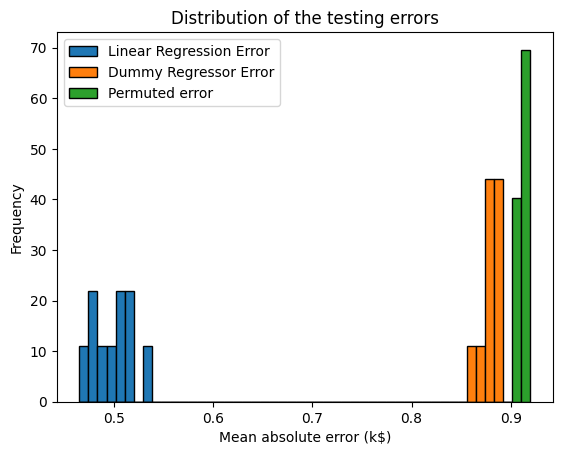

In [47]:
error_df = pd.concat([lin_reg_errors, baseline_median_cv_results_errors, permutation_error], axis=1)

error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(loc="best")
plt.xlabel( "Mean absolute error (k$)")
_ = plt.title("Distribution of the testing errors")

# Conclusion

Our model has performed far better than Baseline Errir! but it can be imporved even further

# SGDRegressor

In [48]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import validation_curve

In [78]:
X_n_train,  X_n_test, y_n_train, y_n_test = train_test_split(X_train, y_train, random_state=42)

In [79]:
print(X_n_train.shape)
print(X_n_test.shape)
print(y_n_train.shape)
print(y_n_test.shape)

(11610, 8)
(3870, 8)
(11610,)
(3870,)


## Baseline SGD Regressor

In [82]:
sgd = SGDRegressor(random_state=42)
sgd.fit(X_n_train, y_n_train)

train_mae = mean_absolute_error(y_n_train, sgd.predict(X_n_train))
dev_mae = mean_absolute_error(y_n_test, sgd.predict(X_n_test))

print('Mean absolute error on training dataset', train_mae)
print('Mean absolute error on test dataset', dev_mae)

Mean absolute error on training dataset 3092971236677614.5
Mean absolute error on test dataset 3054277940448545.5


## Adding a Feature Scaling step

In [84]:
sgd_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("sgd", SGDRegressor())
])
sgd_pipeline.fit(X_n_train, y_n_train)
train_mae = mean_absolute_error(y_n_train, sgd_pipeline.predict(X_n_train))
dev_mae = mean_absolute_error(y_n_test, sgd_pipeline.predict(X_n_test))

print('Mean absolute error on training dataset', train_mae)
print('Mean absolute error on test dataset', dev_mae)

Mean absolute error on training dataset 0.5123133865666695
Mean absolute error on test dataset 0.4918227640558841


Error is still high, will run SGD Step by step

## Step-wise training of sGDRegressor

Text(0.5, 1.0, 'Learning curve: eta0=0.0100')

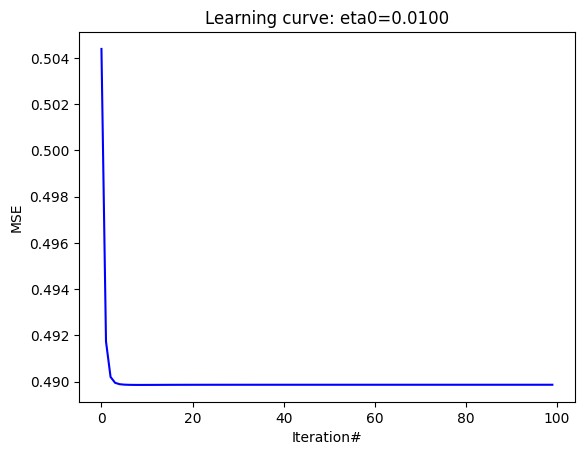

In [89]:
eta0 = 1e-2
sgd_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("sgd", SGDRegressor(max_iter=1, tol=None, 
                         warm_start=True, random_state=42))
])

loss = []
for epoch in range(100):
    sgd_pipeline.fit(X_n_train,y_n_train)
    loss.append(mean_squared_error(y_n_train, sgd_pipeline.predict(X_n_train)))


plt.plot(np.arange(len(loss)), loss,'b-')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')


Text(0.5, 1.0, 'Learning curve: eta0=0.0010')

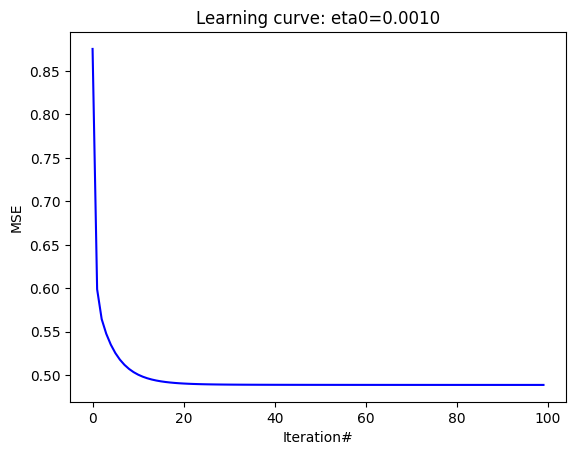

In [90]:
eta0 = 1e-3
sgd_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("sgd", SGDRegressor(max_iter=1, tol=None, 
                         warm_start=True, random_state=42, eta0=eta0))
])

loss = []
for epoch in range(100):
    sgd_pipeline.fit(X_n_train,y_n_train)
    loss.append(mean_squared_error(y_n_train, sgd_pipeline.predict(X_n_train)))


plt.plot(np.arange(len(loss)), loss,'b-')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')


## Fixing through Validation Curve

In [92]:
eta0 = [1e-5, 1e-4, 1e-3, 1e-2]
train_scores, test_scores = validation_curve(sgd_pipeline, X_train, y_train, param_name="sgd__eta0"
                                             , param_range=eta0, cv=cv, scoring="neg_mean_squared_error", n_jobs=2)

train_errors, test_errors = -train_scores, -test_scores

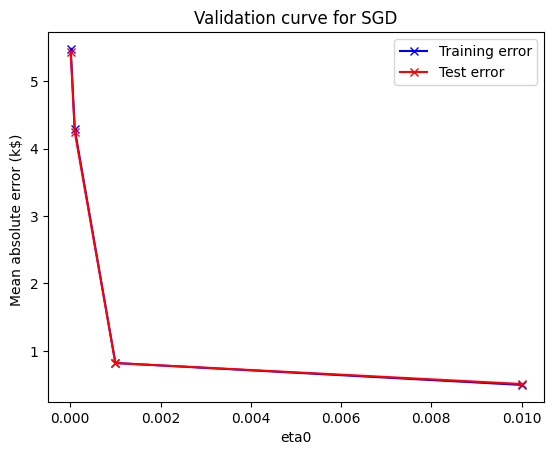

In [93]:
plt.plot(eta0, train_errors.mean(axis=1), 'b-x', label="Training error")
plt.plot(eta0, test_errors.mean(axis=1), 'r-x', label="Test error")
plt.legend()
plt.xlabel("eta0")
plt.ylabel("Mean absolute error (k$) ")
_ = plt.title("Validation curve for SGD")

## SGDRegressor

In [ ]:
sgd_pipeline = 